In [1]:
#This is a demo of combining a pic of a dog and a painting

In [2]:
#Common Libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#Pytorch Packages
import torch
from torch import nn, optim
from torchvision import transforms, models

In [4]:
#Package for image manipulation
from PIL import Image

In [5]:
#Uploading the image
imsize = 224

loader = transforms.Compose([
            transforms.Resize(imsize),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406),
                                (0.229, 0.224, 0.225))
])

In [6]:
#function that uploads the image
def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    
    return image

In [7]:
#uploading the images
content_img = image_loader("dog.jpg")
style_img = image_loader("matisse.jpg")

In [8]:
unloader = transforms.Compose([
            transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225)),
            transforms.ToPILImage()
])

In [9]:
#function that applies the transformations to the tensor
def tensor2image(tensor):
    image = tensor.clone()
    image = image.squeeze(0)
    image = unloader(image)
    
    return image

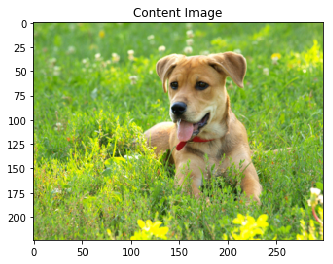

In [10]:
#Looking at first image
plt.figure()
plt.imshow(tensor2image(content_img))
plt.title("Content Image")
plt.show()

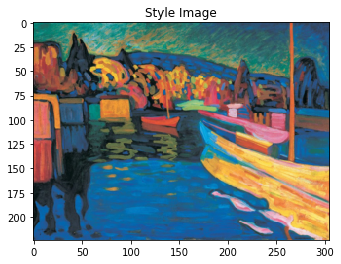

In [11]:
#Looking at second image
plt.figure()
plt.imshow(tensor2image(style_img))
plt.title("Style Image")
plt.show()

In [12]:
#using a pre-trained model called vgg19 
model = models.vgg19(pretrained=True).features
#looking at the features in vgg19
for param in model.parameters():
    param.requires_grad_(False)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /Users/Afrochemist/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 574673361/574673361 [01:20<00:00, 7175629.31it/s] 


In [13]:
#Looking at the model
print(model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [14]:
#Making a dictionary the index of the relevant layers
relevant_layers = {'0': 'conv1_1', '5': 'conv2_1', '10': 'conv3_1', '19': 'conv4_1', '21': 'conv4_2', '28': 'conv5_1'}

In [19]:
#function that will extract the relevant features
def features_extractor(x, model, layers):
    features = {}
    for index, layer in model._modules.items():
        if index in layers:
            x = layer(x)
            features[layers[index]] = x
    return features

In [20]:
content_features = features_extractor(content_img, model, relevant_layers)
style_features = features_extractor(style_img, model, relevant_layers)

In [21]:
style_grams = {}
for i in style_features:
    layer = style_features[i]
    _, d1, d2, d3 = layer.shape
    features = layer.view(d1, d2 * d3)
    gram = torch.mm(features, features.t())
    style_grams[i] = gram

In [22]:
#Target that will be used to compared both imags of the dog and the painting
target_img = content_img.clone().requires_grad_(True)

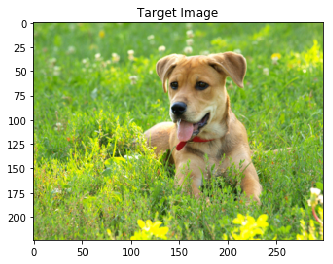

In [24]:
#Showing the target image
plt.figure()
plt.imshow(tensor2image(target_img))
plt.title('Target Image')
plt.show()

In [25]:
style_weights = {'conv1_1': 1., 'conv2_1': 0.8, 'conv3_1': 0.6, 'conv4_1': 0.4, 'conv5_1': 0.2}


In [ ]:
#Preparing for the for loop
alpha = 1
beta = 1e6
print_statement = 500
optimizer = torch.optim.Adam([target_img], lr=0.001)
iterations = 2000

In [ ]:
#Time to light up the torch
for i in range(1, iterations+1):
    target_features = features_extractor(target_img, model, relevant_layers)
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)

    style_losses = 0
    for layer in style_weights:
        target_feature = target_features[layer]
        _, d1, d2, d3 = target_feature.shape

    target_reshaped = target_feature.view(d1, d2 * d3)
    target_gram = torch.mm(target_reshaped, target_reshaped.t())
    style_gram = style_grams[layer]

    style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
    style_losses += style_loss / (d1 * d2 * d3)

    total_loss = alpha * content_loss + beta * style_loss

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    

In [ ]:
if  i % print_statement == 0 or i == 1:
    print('Total loss: ', total_loss.item())
    plt.imshow(tensor2image(target_img))
    plt.show()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(tensor2image(content_img))
ax2.imshow(tensor2image(target_img))
plt.show()